In [ ]:
import os
import time
import random
import numpy as np
import pandas as pd
import sentencepiece as spm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from jiwer import wer, cer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle
import re

In [24]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [25]:
# Check if GPU is available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


In [26]:
# Create output directory
OUTPUT_DIR = './output_lstm_subword/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [27]:
# Paths for saving/loading
DATASET_PATH = './exportStatements.xlsx'
TOKENIZER_MODEL_PATH = os.path.join(OUTPUT_DIR, 'sentencepiece.model')
TOKENIZER_VOCAB_PATH = os.path.join(OUTPUT_DIR, 'sentencepiece.vocab')
PREPROCESSED_DATA_PATH = os.path.join(OUTPUT_DIR, 'preprocessed_data_subword.pkl')
BEST_MODEL_PATH = os.path.join(OUTPUT_DIR, 'best_lstm_model_subword.pt')
BEST_CER_MODEL_PATH = os.path.join(OUTPUT_DIR, 'best_lstm_model_cer.pt')
LOSS_PLOT_PATH = os.path.join(OUTPUT_DIR, 'lstm_loss_plot_subword.png')
ER_PLOT_PATH = os.path.join(OUTPUT_DIR, 'er_plot_subword.png')

In [28]:
# Load the dataset
df = pd.read_excel(DATASET_PATH)

In [29]:
# Check for missing values in 'inFormalForm' and 'FormalForm'
print("Missing values in 'inFormalForm':", df['inFormalForm'].isnull().sum())
print("Missing values in 'FormalForm':", df['FormalForm'].isnull().sum())

# Drop rows with missing values in 'inFormalForm' and 'FormalForm'
initial_length = len(df)
df = df.dropna(subset=['inFormalForm', 'FormalForm']).reset_index(drop=True)
final_length = len(df)

df['inFormalForm'] = df['inFormalForm'].astype(str)
df['FormalForm'] = df['FormalForm'].astype(str)

print(f"Dropped {initial_length - final_length} rows due to missing values.")

Missing values in 'inFormalForm': 0
Missing values in 'FormalForm': 1
Dropped 1 rows due to missing values.


In [30]:
def clean_persian_text(text):
    # 1. Keep only Persian letters, English letters, digits, whitespace, ZWNJ
    text = re.sub(r"[^\u0600-\u06FFa-zA-Z0-9\u06F0-\u06F9\u0660-\u0669\u200c\s]", " ", text)
    # Remove leftover Persian punctuations explicitly (، ؛ ؟)
    text = re.sub(r"[،؛؟]", " ", text)
    # Remove Arabic diacritics (harakat)
    arabic_diacritics = r"[\u064B-\u065F\u0670\u06D6-\u06ED]"
    text = re.sub(arabic_diacritics, "", text)

    # 2. Normalize Persian/Arabic digits to Western digits
    persian_digits = "۰۱۲۳۴۵۶۷۸۹"
    arabic_digits = "٠١٢٣٤٥٦٧٨٩"
    for p, a, e in zip(persian_digits, arabic_digits, "0123456789"):
        text = text.replace(p, e).replace(a, e)

    # 3. Separate numbers stuck to Persian/English letters
    text = re.sub(r"(\d+)(?=[\u0600-\u06FFa-zA-Z])", r"\1 ", text)  # digit before letter
    text = re.sub(r"([\u0600-\u06FFa-zA-Z])(?=\d+)", r"\1 ", text)  # letter before digit

    # 4. Remove underscores
    text = re.sub(r"_+", "", text)

    # 5. Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [31]:
df['inFormalForm'] = df['inFormalForm'].apply(clean_persian_text)
df['FormalForm'] = df['FormalForm'].apply(clean_persian_text)

In [32]:
# Split data into training, validation, and test sets (80%, 10%, 10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

In [ ]:
# Check if tokenizer model exists
if not os.path.exists(TOKENIZER_MODEL_PATH):
    print('Training SentencePiece tokenizer...')
    # Save combined sentences for tokenizer training
    all_sentences_path = os.path.join(OUTPUT_DIR, 'all_sentences.txt')
    with open(all_sentences_path, 'w', encoding='utf-8') as f:
        for sent in pd.concat([train_df['inFormalForm'], train_df['FormalForm']]):
            f.write(sent.strip() + '\n')

    # Adjusted vocab_size
    spm.SentencePieceTrainer.Train(
        input=all_sentences_path,
        model_prefix=os.path.join(OUTPUT_DIR, 'sentencepiece'),
        vocab_size=10000,
        model_type='unigram',
        character_coverage=1.0,
        pad_id=0,      # ID for <pad>
        unk_id=1,      # ID for <unk> (reserved, do not redefine)
        bos_id=2,      # ID for <s> (reserved)
        eos_id=3,      # ID for </s> (reserved)
    )
    print('Tokenizer trained and saved.')
else:
    print('Loading existing tokenizer.')

Training SentencePiece tokenizer...
Tokenizer trained and saved.


In [ ]:
# Load the trained tokenizer
sp = spm.SentencePieceProcessor()
sp.Load(TOKENIZER_MODEL_PATH)
print(f'Vocabulary size: {sp.get_piece_size()}')

# Special token IDs
PAD_IDX = sp.piece_to_id('<pad>')   # Should be 0
UNK_IDX = sp.piece_to_id('<unk>')   # Should be 1
BOS_IDX = sp.piece_to_id('<s>')     # Should be 2
EOS_IDX = sp.piece_to_id('</s>')    # Should be 3

PAD_IDX, UNK_IDX, BOS_IDX, EOS_IDX, sp.pad_id(), sp.unk_id(), sp.bos_id(), sp.eos_id()

Vocabulary size: 10000


(0, 1, 2, 3, 0, 1, 2, 3)

In [35]:
# Maximum sequence length (based on dataset)
def get_max_len(df_list):
    max_len = 0
    for df in df_list:
        lengths = df['inFormalForm'].apply(lambda x: len(sp.EncodeAsIds(x)) + 2)  # +2 for BOS and EOS
        lengths_trg = df['FormalForm'].apply(lambda x: len(sp.EncodeAsIds(x)) + 2)
        max_len = max(max_len, lengths.max(), lengths_trg.max())
    return max_len

MAX_LEN = get_max_len([train_df, val_df, test_df])
MAX_LEN

101

In [36]:
# Check if preprocessed data exists
if not os.path.exists(PREPROCESSED_DATA_PATH):
    print('Preprocessing data...')
    # Preprocess and tokenize all sentences
    def preprocess_data(df, sp, max_len=MAX_LEN):
        src_texts = df['inFormalForm'].tolist()
        trg_texts = df['FormalForm'].tolist()
        src_sequences = []
        trg_sequences = []
        for src, trg in zip(src_texts, trg_texts):
            src_ids = [BOS_IDX] + sp.EncodeAsIds(src) + [EOS_IDX]
            trg_ids = [BOS_IDX] + sp.EncodeAsIds(trg) + [EOS_IDX]
            # Pad or truncate sequences
            src_ids = src_ids[:max_len] + [PAD_IDX] * max(0, max_len - len(src_ids))
            trg_ids = trg_ids[:max_len] + [PAD_IDX] * max(0, max_len - len(trg_ids))
            src_sequences.append(src_ids)
            trg_sequences.append(trg_ids)
        return src_sequences, trg_sequences
    
    # Tokenize and preprocess data
    train_src, train_trg = preprocess_data(train_df, sp)
    val_src, val_trg = preprocess_data(val_df, sp)
    test_src, test_trg = preprocess_data(test_df, sp)

    # Save preprocessed data
    with open(PREPROCESSED_DATA_PATH, 'wb') as f:
        pickle.dump({
            'train_src': train_src,
            'train_trg': train_trg,
            'val_src': val_src,
            'val_trg': val_trg,
            'test_src': test_src,
            'test_trg': test_trg,
            'MAX_LEN': MAX_LEN
        }, f)
    print('Preprocessed data saved.')
else:
    print('Loading preprocessed data...')
    # Load preprocessed data
    with open(PREPROCESSED_DATA_PATH, 'rb') as f:
        data = pickle.load(f)
        train_src = data['train_src']
        train_trg = data['train_trg']
        val_src = data['val_src']
        val_trg = data['val_trg']
        test_src = data['test_src']
        test_trg = data['test_trg']
        MAX_LEN = data['MAX_LEN']

Preprocessing data...
Preprocessed data saved.


In [37]:
# Prepare datasets
class TranslationDataset(Dataset):
    def __init__(self, src_sequences, trg_sequences):
        self.src_sequences = src_sequences
        self.trg_sequences = trg_sequences

    def __len__(self):
        return len(self.src_sequences)

    def __getitem__(self, idx):
        src_ids = torch.tensor(self.src_sequences[idx], dtype=torch.long)
        trg_ids = torch.tensor(self.trg_sequences[idx], dtype=torch.long)
        return src_ids, trg_ids

In [ ]:
# Create datasets and dataloaders
batch_size = 32

train_dataset = TranslationDataset(train_src, train_trg)
val_dataset = TranslationDataset(val_src, val_trg)
test_dataset = TranslationDataset(test_src, test_trg)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Define the LSTM-based Seq2Seq model
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, n_layers, dropout, pad_idx):
        super().__init__()
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx

        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.encoder = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, trg):
        # Embed source and target sequences
        embedded_src = self.dropout(self.embedding(src))
        embedded_trg = self.dropout(self.embedding(trg[:, :-1]))  # Remove last token for decoder input

        # Encode source sequence
        _, (hidden, cell) = self.encoder(embedded_src)

        # Decode target sequence
        outputs, _ = self.decoder(embedded_trg, (hidden, cell))
        predictions = self.fc_out(outputs)

        return predictions

    def predict(self, src, max_len=MAX_LEN):
        # Embed source sequence
        embedded_src = self.dropout(self.embedding(src))

        # Encode source sequence
        _, (hidden, cell) = self.encoder(embedded_src)

        # Initialize target sequence with <s>
        inputs = torch.tensor([BOS_IDX] * src.size(0), dtype=torch.long).unsqueeze(1).to(src.device)
        outputs = []
        finished = torch.zeros(src.size(0), dtype=torch.bool, device=src.device)
        for _ in range(max_len):
            embedded = self.dropout(self.embedding(inputs))
            output, (hidden, cell) = self.decoder(embedded, (hidden, cell))
            prediction = self.fc_out(output.squeeze(1))
            top1 = prediction.argmax(1)
            outputs.append(top1.unsqueeze(1))
            inputs = top1.unsqueeze(1)
            finished = finished | (top1 == EOS_IDX)
            if finished.all():
                break
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [40]:
# Initialize model parameters
VOCAB_SIZE = sp.get_piece_size()
EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
DROPOUT = 0.2

model = Seq2Seq(VOCAB_SIZE, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT, PAD_IDX).to(DEVICE)

In [41]:
# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
def evaluate_wer(model, dataloader, sp, max_batches=None):
    model.eval()
    cer_scores = []
    wer_scores = []
    batches_processed = 0

    with torch.no_grad():
        for src, trg in dataloader:
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)

            outputs = model.predict(src, max_len=MAX_LEN)
            outputs = outputs.cpu().tolist()
            trg = trg.cpu().tolist()

            for pred_ids, trg_ids in zip(outputs, trg):
                
                pred_ids = [i for i in pred_ids if i not in (PAD_IDX, EOS_IDX)]
                trg_ids  = [i for i in trg_ids if i not in (PAD_IDX, EOS_IDX, BOS_IDX)]

                pred_sentence = sp.DecodeIds(pred_ids)
                trg_sentence = sp.DecodeIds(trg_ids)

                cer_score = cer(trg_sentence, pred_sentence)
                wer_score = wer(trg_sentence, pred_sentence)

                cer_scores.append(cer_score)
                wer_scores.append(wer_score)

            batches_processed += 1
            if max_batches and batches_processed >= max_batches:
                break

    avg_cer = float(np.mean(cer_scores))
    avg_wer = float(np.mean(wer_scores))
    return avg_cer, avg_wer

In [ ]:
# Training loop
N_EPOCHS = 100
best_valid_loss = float('inf')
best_valid_cer = float('inf')
patience = 5
counter = 0

train_losses = []
valid_losses = []

train_wers = []
valid_wers = []
train_cers = []
valid_cers = []

for epoch in range(1, N_EPOCHS + 1):
    start_time = time.time()

    # Training
    model.train()
    epoch_train_loss = 0
    for src, trg in tqdm(train_loader, desc=f'Training Epoch {epoch}/{N_EPOCHS}'):
        src = src.to(DEVICE)
        trg = trg.to(DEVICE)

        optimizer.zero_grad()
        output = model(src, trg)

        # Reshape for loss computation
        output = output.reshape(-1, VOCAB_SIZE)
        trg = trg[:, 1:].reshape(-1)  # Remove first token (<s>) for target

        loss = criterion(output, trg)
        loss.backward()

        optimizer.step()

        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for src, trg in tqdm(val_loader, desc=f'Validation Epoch {epoch}/{N_EPOCHS}'):
            src = src.to(DEVICE)
            trg = trg.to(DEVICE)

            output = model(src, trg)

            output = output.reshape(-1, VOCAB_SIZE)
            trg = trg[:, 1:].reshape(-1)  # Remove <BOS>

            loss = criterion(output, trg)
            epoch_valid_loss += loss.item()

    epoch_valid_loss /= len(val_loader)
    valid_losses.append(epoch_valid_loss)
    
    valid_cer, valid_wer = evaluate_wer(model, val_loader, sp)
    valid_wers.append(valid_wer)
    valid_cers.append(valid_cer)
    
    print(f'\tTrain Loss: {epoch_train_loss:.3f}')
    print(f'\tValid Loss: {epoch_valid_loss:.3f}')
    print(f'\tValid WER: {valid_wer:.4f}')
    print(f'\tValid CER: {valid_cer:.4f}')
    
    # Early stopping check
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f'Validation loss improved. Model saved to {BEST_MODEL_PATH}.')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print('Early stopping triggered.')
            break

    if valid_cer < best_valid_cer:
        best_valid_cer = valid_cer
        torch.save(model.state_dict(), BEST_CER_MODEL_PATH)
        print(f'Validation CER improved. Model saved to {BEST_CER_MODEL_PATH}.')

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)

    print(f'Epoch: {epoch:02} | Time: {epoch_mins}m {epoch_secs}s')

Validation Epoch 1/100: 100%|██████████| 157/157 [00:09<00:00, 16.80it/s]


	Train Loss: 6.353
	Valid Loss: 6.013
	Valid WER: 0.9482
	Valid CER: 0.7752
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Validation CER improved. Model saved to ./output_lstm_subword/best_lstm_model_cer.pt.
Epoch: 01 | Time: 3m 22s


Validation Epoch 2/100: 100%|██████████| 157/157 [00:09<00:00, 16.84it/s]


	Train Loss: 5.878
	Valid Loss: 5.738
	Valid WER: 1.0575
	Valid CER: 0.6991
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Validation CER improved. Model saved to ./output_lstm_subword/best_lstm_model_cer.pt.
Epoch: 02 | Time: 3m 27s


Validation Epoch 3/100: 100%|██████████| 157/157 [00:09<00:00, 16.65it/s]


	Train Loss: 5.650
	Valid Loss: 5.584
	Valid WER: 1.2605
	Valid CER: 0.7681
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 03 | Time: 3m 33s


Validation Epoch 4/100: 100%|██████████| 157/157 [00:09<00:00, 16.42it/s]


	Train Loss: 5.517
	Valid Loss: 5.475
	Valid WER: 1.2323
	Valid CER: 0.7504
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 04 | Time: 3m 37s


Validation Epoch 5/100: 100%|██████████| 157/157 [00:09<00:00, 16.41it/s]


	Train Loss: 5.411
	Valid Loss: 5.384
	Valid WER: 1.3991
	Valid CER: 0.8393
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 05 | Time: 3m 37s


Validation Epoch 6/100: 100%|██████████| 157/157 [00:09<00:00, 16.46it/s]


	Train Loss: 5.315
	Valid Loss: 5.299
	Valid WER: 1.3997
	Valid CER: 0.8414
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 06 | Time: 3m 38s


Validation Epoch 7/100: 100%|██████████| 157/157 [00:09<00:00, 16.49it/s]


	Train Loss: 5.225
	Valid Loss: 5.225
	Valid WER: 1.3651
	Valid CER: 0.8618
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 07 | Time: 3m 36s


Validation Epoch 8/100: 100%|██████████| 157/157 [00:09<00:00, 16.46it/s]


	Train Loss: 5.145
	Valid Loss: 5.166
	Valid WER: 1.2954
	Valid CER: 0.8099
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 08 | Time: 3m 38s


Validation Epoch 9/100: 100%|██████████| 157/157 [00:09<00:00, 17.12it/s]


	Train Loss: 5.071
	Valid Loss: 5.098
	Valid WER: 1.3481
	Valid CER: 0.8611
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 09 | Time: 3m 34s


Validation Epoch 10/100: 100%|██████████| 157/157 [00:09<00:00, 17.26it/s]


	Train Loss: 4.991
	Valid Loss: 5.029
	Valid WER: 1.3798
	Valid CER: 0.8591
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 10 | Time: 3m 29s


Validation Epoch 11/100: 100%|██████████| 157/157 [00:09<00:00, 17.29it/s]


	Train Loss: 4.910
	Valid Loss: 4.966
	Valid WER: 1.4000
	Valid CER: 0.8686
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 11 | Time: 3m 29s


Validation Epoch 12/100: 100%|██████████| 157/157 [00:09<00:00, 17.27it/s]


	Train Loss: 4.823
	Valid Loss: 4.884
	Valid WER: 1.3372
	Valid CER: 0.8334
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 12 | Time: 3m 29s


Validation Epoch 13/100: 100%|██████████| 157/157 [00:09<00:00, 17.29it/s]


	Train Loss: 4.734
	Valid Loss: 4.810
	Valid WER: 1.2830
	Valid CER: 0.8215
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 13 | Time: 3m 29s


Validation Epoch 14/100: 100%|██████████| 157/157 [00:09<00:00, 17.22it/s]


	Train Loss: 4.644
	Valid Loss: 4.736
	Valid WER: 1.2428
	Valid CER: 0.8084
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 14 | Time: 3m 29s


Validation Epoch 15/100: 100%|██████████| 157/157 [00:09<00:00, 17.27it/s]


	Train Loss: 4.555
	Valid Loss: 4.660
	Valid WER: 1.2708
	Valid CER: 0.8320
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 15 | Time: 3m 29s


Validation Epoch 16/100: 100%|██████████| 157/157 [00:09<00:00, 17.38it/s]


	Train Loss: 4.469
	Valid Loss: 4.586
	Valid WER: 1.3097
	Valid CER: 0.8532
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 16 | Time: 3m 33s


Validation Epoch 17/100: 100%|██████████| 157/157 [00:09<00:00, 17.40it/s]


	Train Loss: 4.385
	Valid Loss: 4.519
	Valid WER: 1.2246
	Valid CER: 0.8046
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 17 | Time: 3m 25s


Validation Epoch 18/100: 100%|██████████| 157/157 [00:09<00:00, 17.39it/s]


	Train Loss: 4.302
	Valid Loss: 4.456
	Valid WER: 1.2189
	Valid CER: 0.7987
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 18 | Time: 3m 24s


Validation Epoch 19/100: 100%|██████████| 157/157 [00:08<00:00, 17.51it/s]


	Train Loss: 4.225
	Valid Loss: 4.390
	Valid WER: 1.2292
	Valid CER: 0.8057
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 19 | Time: 3m 24s


Validation Epoch 20/100: 100%|██████████| 157/157 [00:09<00:00, 17.27it/s]


	Train Loss: 4.148
	Valid Loss: 4.334
	Valid WER: 1.1969
	Valid CER: 0.7872
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 20 | Time: 3m 25s


Validation Epoch 21/100: 100%|██████████| 157/157 [00:09<00:00, 17.26it/s]


	Train Loss: 4.073
	Valid Loss: 4.280
	Valid WER: 1.1896
	Valid CER: 0.7917
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 21 | Time: 3m 27s


Validation Epoch 22/100: 100%|██████████| 157/157 [00:09<00:00, 17.24it/s]


	Train Loss: 4.001
	Valid Loss: 4.220
	Valid WER: 1.1868
	Valid CER: 0.7865
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 22 | Time: 3m 29s


Validation Epoch 23/100: 100%|██████████| 157/157 [00:09<00:00, 17.25it/s]


	Train Loss: 3.929
	Valid Loss: 4.179
	Valid WER: 1.1559
	Valid CER: 0.7651
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 23 | Time: 3m 28s


Validation Epoch 24/100: 100%|██████████| 157/157 [00:09<00:00, 16.56it/s]


	Train Loss: 3.860
	Valid Loss: 4.120
	Valid WER: 1.1499
	Valid CER: 0.7682
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 24 | Time: 3m 30s


Validation Epoch 25/100: 100%|██████████| 157/157 [00:09<00:00, 16.50it/s]


	Train Loss: 3.793
	Valid Loss: 4.077
	Valid WER: 1.1047
	Valid CER: 0.7477
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 25 | Time: 3m 35s


Validation Epoch 26/100: 100%|██████████| 157/157 [00:09<00:00, 16.35it/s]


	Train Loss: 3.728
	Valid Loss: 4.031
	Valid WER: 1.0797
	Valid CER: 0.7369
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 26 | Time: 3m 36s


Validation Epoch 27/100: 100%|██████████| 157/157 [00:09<00:00, 17.16it/s]


	Train Loss: 3.664
	Valid Loss: 3.984
	Valid WER: 1.1358
	Valid CER: 0.7621
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 27 | Time: 3m 28s


Validation Epoch 28/100: 100%|██████████| 157/157 [00:09<00:00, 17.34it/s]


	Train Loss: 3.603
	Valid Loss: 3.947
	Valid WER: 1.0791
	Valid CER: 0.7323
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 28 | Time: 3m 25s


Validation Epoch 29/100: 100%|██████████| 157/157 [00:09<00:00, 17.34it/s]


	Train Loss: 3.542
	Valid Loss: 3.905
	Valid WER: 1.0882
	Valid CER: 0.7407
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 29 | Time: 3m 26s


Validation Epoch 30/100: 100%|██████████| 157/157 [00:09<00:00, 17.43it/s]


	Train Loss: 3.482
	Valid Loss: 3.870
	Valid WER: 1.0853
	Valid CER: 0.7413
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 30 | Time: 3m 25s


Validation Epoch 31/100: 100%|██████████| 157/157 [00:09<00:00, 17.32it/s]


	Train Loss: 3.425
	Valid Loss: 3.829
	Valid WER: 1.0611
	Valid CER: 0.7290
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 31 | Time: 3m 26s


Validation Epoch 32/100: 100%|██████████| 157/157 [00:09<00:00, 17.33it/s]


	Train Loss: 3.367
	Valid Loss: 3.793
	Valid WER: 1.0174
	Valid CER: 0.7059
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 32 | Time: 3m 24s


Validation Epoch 33/100: 100%|██████████| 157/157 [00:09<00:00, 17.42it/s]


	Train Loss: 3.313
	Valid Loss: 3.761
	Valid WER: 1.0270
	Valid CER: 0.7128
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 33 | Time: 3m 24s


Validation Epoch 34/100: 100%|██████████| 157/157 [00:09<00:00, 16.54it/s]


	Train Loss: 3.260
	Valid Loss: 3.724
	Valid WER: 1.0173
	Valid CER: 0.7078
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 34 | Time: 3m 24s


Validation Epoch 35/100: 100%|██████████| 157/157 [00:09<00:00, 17.33it/s]


	Train Loss: 3.207
	Valid Loss: 3.700
	Valid WER: 1.0090
	Valid CER: 0.7033
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 35 | Time: 3m 27s


Validation Epoch 36/100: 100%|██████████| 157/157 [00:08<00:00, 17.60it/s]


	Train Loss: 3.154
	Valid Loss: 3.670
	Valid WER: 1.0008
	Valid CER: 0.6981
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Validation CER improved. Model saved to ./output_lstm_subword/best_lstm_model_cer.pt.
Epoch: 36 | Time: 3m 23s


Validation Epoch 37/100: 100%|██████████| 157/157 [00:08<00:00, 17.64it/s]


	Train Loss: 3.104
	Valid Loss: 3.644
	Valid WER: 0.9807
	Valid CER: 0.6889
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Validation CER improved. Model saved to ./output_lstm_subword/best_lstm_model_cer.pt.
Epoch: 37 | Time: 3m 22s


Validation Epoch 38/100: 100%|██████████| 157/157 [00:09<00:00, 16.90it/s]


	Train Loss: 3.055
	Valid Loss: 3.621
	Valid WER: 0.9662
	Valid CER: 0.6836
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Validation CER improved. Model saved to ./output_lstm_subword/best_lstm_model_cer.pt.
Epoch: 38 | Time: 3m 28s


Validation Epoch 39/100: 100%|██████████| 157/157 [00:09<00:00, 17.26it/s]


	Train Loss: 3.008
	Valid Loss: 3.592
	Valid WER: 0.9824
	Valid CER: 0.6884
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 39 | Time: 3m 27s


Validation Epoch 40/100: 100%|██████████| 157/157 [00:09<00:00, 17.19it/s]


	Train Loss: 2.960
	Valid Loss: 3.564
	Valid WER: 1.0194
	Valid CER: 0.7158
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 40 | Time: 3m 27s


Validation Epoch 41/100: 100%|██████████| 157/157 [00:09<00:00, 17.23it/s]


	Train Loss: 2.913
	Valid Loss: 3.548
	Valid WER: 1.0765
	Valid CER: 0.7494
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 41 | Time: 3m 28s


Validation Epoch 42/100: 100%|██████████| 157/157 [00:09<00:00, 17.14it/s]


	Train Loss: 2.867
	Valid Loss: 3.523
	Valid WER: 1.0796
	Valid CER: 0.7513
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 42 | Time: 3m 28s


Validation Epoch 43/100: 100%|██████████| 157/157 [00:09<00:00, 17.24it/s]


	Train Loss: 2.820
	Valid Loss: 3.502
	Valid WER: 0.9404
	Valid CER: 0.6702
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Validation CER improved. Model saved to ./output_lstm_subword/best_lstm_model_cer.pt.
Epoch: 43 | Time: 3m 29s


Validation Epoch 44/100: 100%|██████████| 157/157 [00:09<00:00, 17.17it/s]


	Train Loss: 2.778
	Valid Loss: 3.481
	Valid WER: 0.9632
	Valid CER: 0.6860
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 44 | Time: 3m 28s


Validation Epoch 45/100: 100%|██████████| 157/157 [00:09<00:00, 17.27it/s]


	Train Loss: 2.734
	Valid Loss: 3.465
	Valid WER: 0.9781
	Valid CER: 0.6966
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 45 | Time: 3m 28s


Validation Epoch 46/100: 100%|██████████| 157/157 [00:09<00:00, 16.32it/s]


	Train Loss: 2.691
	Valid Loss: 3.441
	Valid WER: 0.9103
	Valid CER: 0.6561
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Validation CER improved. Model saved to ./output_lstm_subword/best_lstm_model_cer.pt.
Epoch: 46 | Time: 3m 37s


Validation Epoch 47/100: 100%|██████████| 157/157 [00:09<00:00, 16.51it/s]


	Train Loss: 2.650
	Valid Loss: 3.423
	Valid WER: 0.9067
	Valid CER: 0.6536
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Validation CER improved. Model saved to ./output_lstm_subword/best_lstm_model_cer.pt.
Epoch: 47 | Time: 3m 37s


Validation Epoch 48/100: 100%|██████████| 157/157 [00:09<00:00, 16.55it/s]


	Train Loss: 2.610
	Valid Loss: 3.410
	Valid WER: 0.9123
	Valid CER: 0.6605
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 48 | Time: 3m 37s


Validation Epoch 49/100: 100%|██████████| 157/157 [00:09<00:00, 16.47it/s]


	Train Loss: 2.569
	Valid Loss: 3.389
	Valid WER: 0.9269
	Valid CER: 0.6680
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 49 | Time: 3m 38s


Validation Epoch 50/100: 100%|██████████| 157/157 [00:09<00:00, 16.47it/s]


	Train Loss: 2.530
	Valid Loss: 3.374
	Valid WER: 0.9041
	Valid CER: 0.6624
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 50 | Time: 3m 37s


Validation Epoch 51/100: 100%|██████████| 157/157 [00:09<00:00, 16.59it/s]


	Train Loss: 2.490
	Valid Loss: 3.356
	Valid WER: 0.9029
	Valid CER: 0.6568
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 51 | Time: 3m 36s


Validation Epoch 52/100: 100%|██████████| 157/157 [00:09<00:00, 16.54it/s]


	Train Loss: 2.454
	Valid Loss: 3.345
	Valid WER: 0.9551
	Valid CER: 0.6981
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 52 | Time: 3m 36s


Validation Epoch 53/100: 100%|██████████| 157/157 [00:09<00:00, 16.53it/s]


	Train Loss: 2.415
	Valid Loss: 3.336
	Valid WER: 0.9947
	Valid CER: 0.7352
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 53 | Time: 3m 37s


Validation Epoch 54/100: 100%|██████████| 157/157 [00:09<00:00, 16.51it/s]


	Train Loss: 2.377
	Valid Loss: 3.326
	Valid WER: 0.9959
	Valid CER: 0.7348
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 54 | Time: 3m 37s


Validation Epoch 55/100: 100%|██████████| 157/157 [00:09<00:00, 16.49it/s]


	Train Loss: 2.341
	Valid Loss: 3.308
	Valid WER: 1.0417
	Valid CER: 0.7607
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 55 | Time: 3m 37s


Validation Epoch 56/100: 100%|██████████| 157/157 [00:09<00:00, 16.44it/s]


	Train Loss: 2.306
	Valid Loss: 3.299
	Valid WER: 1.1028
	Valid CER: 0.8497
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 56 | Time: 3m 37s


Validation Epoch 57/100: 100%|██████████| 157/157 [00:09<00:00, 16.52it/s]


	Train Loss: 2.270
	Valid Loss: 3.291
	Valid WER: 1.0428
	Valid CER: 0.7959
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 57 | Time: 3m 38s


Validation Epoch 58/100: 100%|██████████| 157/157 [00:09<00:00, 16.51it/s]


	Train Loss: 2.236
	Valid Loss: 3.271
	Valid WER: 1.0200
	Valid CER: 0.7596
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 58 | Time: 3m 37s


Validation Epoch 59/100: 100%|██████████| 157/157 [00:09<00:00, 16.50it/s]


	Train Loss: 2.202
	Valid Loss: 3.271
	Valid WER: 1.0030
	Valid CER: 0.7350
Epoch: 59 | Time: 3m 37s


Validation Epoch 60/100: 100%|██████████| 157/157 [00:09<00:00, 16.50it/s]


	Train Loss: 2.171
	Valid Loss: 3.262
	Valid WER: 0.9613
	Valid CER: 0.7188
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 60 | Time: 3m 37s


Validation Epoch 61/100: 100%|██████████| 157/157 [00:09<00:00, 16.38it/s]


	Train Loss: 2.135
	Valid Loss: 3.248
	Valid WER: 1.1146
	Valid CER: 0.8459
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 61 | Time: 3m 37s


Validation Epoch 62/100: 100%|██████████| 157/157 [00:09<00:00, 16.46it/s]


	Train Loss: 2.102
	Valid Loss: 3.241
	Valid WER: 0.9611
	Valid CER: 0.7237
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 62 | Time: 3m 36s


Validation Epoch 63/100: 100%|██████████| 157/157 [00:09<00:00, 17.19it/s]


	Train Loss: 2.071
	Valid Loss: 3.235
	Valid WER: 0.9178
	Valid CER: 0.6849
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 63 | Time: 3m 35s


Validation Epoch 64/100: 100%|██████████| 157/157 [00:09<00:00, 17.21it/s]


	Train Loss: 2.041
	Valid Loss: 3.230
	Valid WER: 0.9704
	Valid CER: 0.7326
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 64 | Time: 3m 28s


Validation Epoch 65/100: 100%|██████████| 157/157 [00:09<00:00, 16.41it/s]


	Train Loss: 2.009
	Valid Loss: 3.229
	Valid WER: 1.0545
	Valid CER: 0.7930
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 65 | Time: 3m 35s


Validation Epoch 66/100: 100%|██████████| 157/157 [00:09<00:00, 16.51it/s]


	Train Loss: 1.980
	Valid Loss: 3.216
	Valid WER: 1.0129
	Valid CER: 0.7746
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 66 | Time: 3m 37s


Validation Epoch 67/100: 100%|██████████| 157/157 [00:09<00:00, 16.54it/s]


	Train Loss: 1.950
	Valid Loss: 3.217
	Valid WER: 1.0628
	Valid CER: 0.8263
Epoch: 67 | Time: 3m 36s


Validation Epoch 68/100: 100%|██████████| 157/157 [00:09<00:00, 16.43it/s]


	Train Loss: 1.920
	Valid Loss: 3.211
	Valid WER: 1.1230
	Valid CER: 0.8810
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 68 | Time: 3m 37s


Validation Epoch 69/100: 100%|██████████| 157/157 [00:09<00:00, 16.54it/s]


	Train Loss: 1.889
	Valid Loss: 3.204
	Valid WER: 1.0565
	Valid CER: 0.8157
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 69 | Time: 3m 37s


Validation Epoch 70/100: 100%|██████████| 157/157 [00:09<00:00, 16.51it/s]


	Train Loss: 1.864
	Valid Loss: 3.199
	Valid WER: 1.1217
	Valid CER: 0.8649
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 70 | Time: 3m 37s


Validation Epoch 71/100: 100%|██████████| 157/157 [00:09<00:00, 16.41it/s]


	Train Loss: 1.834
	Valid Loss: 3.196
	Valid WER: 1.1833
	Valid CER: 0.9137
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 71 | Time: 3m 37s


Validation Epoch 72/100: 100%|██████████| 157/157 [00:09<00:00, 16.47it/s]


	Train Loss: 1.807
	Valid Loss: 3.196
	Valid WER: 1.0905
	Valid CER: 0.8461
Epoch: 72 | Time: 3m 37s


Validation Epoch 73/100: 100%|██████████| 157/157 [00:09<00:00, 16.40it/s]


	Train Loss: 1.779
	Valid Loss: 3.191
	Valid WER: 1.1799
	Valid CER: 0.8974
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 73 | Time: 3m 37s


Validation Epoch 74/100: 100%|██████████| 157/157 [00:09<00:00, 16.43it/s]


	Train Loss: 1.753
	Valid Loss: 3.189
	Valid WER: 1.0832
	Valid CER: 0.8318
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 74 | Time: 3m 38s


Validation Epoch 75/100: 100%|██████████| 157/157 [00:09<00:00, 16.50it/s]


	Train Loss: 1.727
	Valid Loss: 3.191
	Valid WER: 1.0286
	Valid CER: 0.7870
Epoch: 75 | Time: 3m 36s


Validation Epoch 76/100: 100%|██████████| 157/157 [00:09<00:00, 16.41it/s]


	Train Loss: 1.699
	Valid Loss: 3.188
	Valid WER: 1.0266
	Valid CER: 0.7875
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 76 | Time: 3m 37s


Validation Epoch 77/100: 100%|██████████| 157/157 [00:09<00:00, 16.33it/s]


	Train Loss: 1.675
	Valid Loss: 3.190
	Valid WER: 0.9205
	Valid CER: 0.6966
Epoch: 77 | Time: 3m 37s


Validation Epoch 78/100: 100%|██████████| 157/157 [00:09<00:00, 16.58it/s]


	Train Loss: 1.650
	Valid Loss: 3.185
	Valid WER: 0.9257
	Valid CER: 0.6991
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 78 | Time: 3m 37s


Validation Epoch 79/100: 100%|██████████| 157/157 [00:09<00:00, 17.17it/s]


	Train Loss: 1.623
	Valid Loss: 3.187
	Valid WER: 0.9468
	Valid CER: 0.7244
Epoch: 79 | Time: 3m 36s


Validation Epoch 80/100: 100%|██████████| 157/157 [00:09<00:00, 17.16it/s]


	Train Loss: 1.601
	Valid Loss: 3.178
	Valid WER: 0.9187
	Valid CER: 0.6957
Validation loss improved. Model saved to ./output_lstm_subword/best_lstm_model_subword.pt.
Epoch: 80 | Time: 3m 32s


Validation Epoch 81/100: 100%|██████████| 157/157 [00:09<00:00, 16.38it/s]


	Train Loss: 1.576
	Valid Loss: 3.180
	Valid WER: 0.9435
	Valid CER: 0.7130
Epoch: 81 | Time: 3m 33s


Validation Epoch 82/100: 100%|██████████| 157/157 [00:09<00:00, 16.42it/s]


	Train Loss: 1.553
	Valid Loss: 3.179
	Valid WER: 0.8884
	Valid CER: 0.6728
Epoch: 82 | Time: 3m 36s


Validation Epoch 83/100: 100%|██████████| 157/157 [00:09<00:00, 17.14it/s]


	Train Loss: 1.530
	Valid Loss: 3.183
	Valid WER: 0.8453
	Valid CER: 0.6328
Validation CER improved. Model saved to ./output_lstm_subword/best_lstm_model_cer.pt.
Epoch: 83 | Time: 3m 33s


Validation Epoch 84/100: 100%|██████████| 157/157 [00:09<00:00, 17.16it/s]


	Train Loss: 1.507
	Valid Loss: 3.182
	Valid WER: 0.8803
	Valid CER: 0.6658
Epoch: 84 | Time: 3m 35s


Validation Epoch 85/100: 100%|██████████| 157/157 [00:09<00:00, 16.43it/s]


	Train Loss: 1.484
	Valid Loss: 3.182
	Valid WER: 0.8763
	Valid CER: 0.6626
Early stopping triggered.


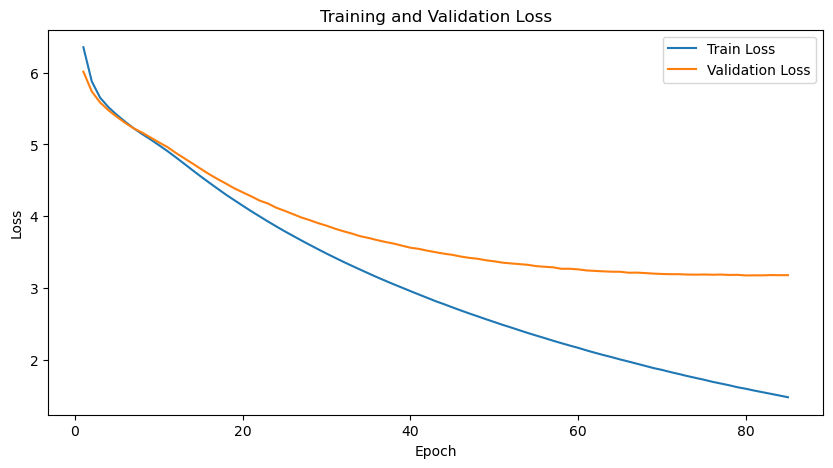

Loss plot saved to ./output_lstm_subword/lstm_loss_plot_subword.png.


In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig(LOSS_PLOT_PATH)
plt.show()
print(f'Loss plot saved to {LOSS_PLOT_PATH}.')

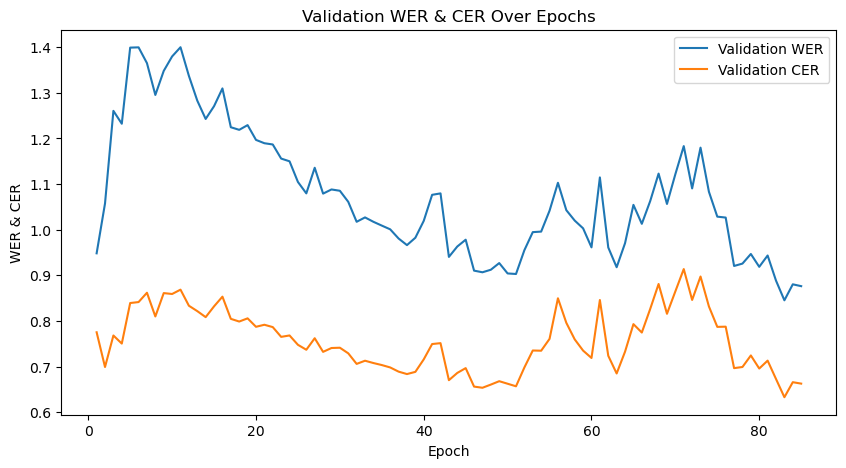

Plot saved to ./output_lstm_subword/er_plot_subword.png.


In [ ]:
# Plot validation CER & WER over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(valid_wers) + 1), valid_wers, label='Validation WER')
plt.plot(range(1, len(valid_cers) + 1), valid_cers, label='Validation CER')
plt.xlabel('Epoch')
plt.ylabel('WER & CER')
plt.legend()
plt.title('Validation WER & CER Over Epochs')
plt.savefig(ER_PLOT_PATH)

plt.show()
print(f'Plot saved to {ER_PLOT_PATH}.')

In [ ]:
def translate_sentence(sentence, model, sp, device, max_len=MAX_LEN):
    model.eval()
    tokens = [BOS_IDX] + sp.EncodeAsIds(sentence) + [EOS_IDX]
    tokens = tokens[:max_len] + [PAD_IDX] * max(0, max_len - len(tokens))
    src_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model.predict(src_tensor, max_len)
    outputs = outputs.squeeze(0).tolist()

    # Stop at EOS token
    if EOS_IDX in outputs:
        eos_index = outputs.index(EOS_IDX)
        outputs = outputs[:eos_index]
    # Remove PAD and EOS tokens
    outputs = [idx for idx in outputs if idx not in [PAD_IDX, EOS_IDX]]
    translation = sp.DecodeIds(outputs)
    return translation

In [ ]:
def evaluate_and_save(model, df, src_sequences, trg_sequences, sp, file_name):
    model.eval()
    predictions = []
    cer_scores = []
    wer_scores = []

    for src_ids, trg_ids in tqdm(zip(src_sequences, trg_sequences), total=len(src_sequences), desc=f'Evaluating {file_name}'):
        src_sentence = sp.DecodeIds([id for id in src_ids if id not in [BOS_IDX, EOS_IDX, PAD_IDX]])
        trg_sentence = sp.DecodeIds([id for id in trg_ids if id not in [BOS_IDX, EOS_IDX, PAD_IDX]])

        pred_sentence = translate_sentence(src_sentence, model, sp, DEVICE)
        predictions.append(pred_sentence)
        cer_score = cer(trg_sentence, pred_sentence)
        wer_score = wer(trg_sentence, pred_sentence)
        cer_scores.append(cer_score)
        wer_scores.append(wer_score)

    results_df = pd.DataFrame({
        'Source': df['inFormalForm'],
        'Target': df['FormalForm'],
        'Prediction': predictions,
        'CER': cer_scores,
        'WER': wer_scores
    })

    results_df = results_df.sort_values(by=['CER', 'WER'], ascending=[True, True])

    results_path = os.path.join(OUTPUT_DIR, file_name)
    results_df.to_csv(results_path, index=False)
    avg_cer = np.mean(cer_scores)
    avg_wer = np.mean(wer_scores)
    print(f'Results saved to {results_path}')
    print(f'Average CER: {avg_cer:.4f}')
    print(f'Average WER: {avg_wer:.4f}')
    return results_df

In [ ]:
model.load_state_dict(torch.load(BEST_MODEL_PATH))
print('Best model loaded.')

print('Evaluating on training data...')
train_results = evaluate_and_save(model, train_df, train_src, train_trg, sp, 'train_results_subword_lstm.csv')

print('Evaluating on validation data...')
val_results = evaluate_and_save(model, val_df, val_src, val_trg, sp, 'val_results_subword_lstm.csv')

print('Evaluating on test data...')
test_results = evaluate_and_save(model, test_df, test_src, test_trg, sp, 'test_results_subword_lstm.csv')

C:\Users\HiRaD\AppData\Local\Temp\ipykernel_16068\4093574819.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BEST_MODEL_PATH))


Best model loaded.
Evaluating on training data...


Evaluating train_results_subword_lstm.csv: 100%|██████████| 40008/40008 [12:37<00:00, 52.80it/s]


Results saved to ./output_lstm_subword/train_results_subword_lstm.csv
Average CER: 0.4539
Average WER: 0.6047
Evaluating on validation data...


Evaluating val_results_subword_lstm.csv: 100%|██████████| 5001/5001 [01:35<00:00, 52.52it/s]


Results saved to ./output_lstm_subword/val_results_subword_lstm.csv
Average CER: 0.5979
Average WER: 0.7995
Evaluating on test data...


Evaluating test_results_subword_lstm.csv: 100%|██████████| 5002/5002 [01:38<00:00, 50.83it/s]


Results saved to ./output_lstm_subword/test_results_subword_lstm.csv
Average CER: 0.5941
Average WER: 0.7964


In [ ]:
model.load_state_dict(torch.load(BEST_CER_MODEL_PATH))
print('Best CER model loaded.')

print('Evaluating on training data using best CER model...')
train_results = evaluate_and_save(model, train_df, train_src, train_trg, sp, 'train_results_subword_best_cer.csv')

print('Evaluating on validation data using best CER model...')
val_results = evaluate_and_save(model, val_df, val_src, val_trg, sp, 'val_results_subword_best_cer.csv')

print('Evaluating on test data using best CER model...')
test_results = evaluate_and_save(model, test_df, test_src, test_trg, sp, 'test_results_subword_best_cer.csv')

C:\Users\HiRaD\AppData\Local\Temp\ipykernel_16068\2110300272.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BEST_CER_MODEL_PATH))


Best CER model loaded.
Evaluating on training data using best CER model...


Evaluating train_results_subword_best_cer.csv: 100%|██████████| 40008/40008 [12:43<00:00, 52.39it/s]


Results saved to ./output_lstm_subword/train_results_subword_best_cer.csv
Average CER: 0.4445
Average WER: 0.5930
Evaluating on validation data using best CER model...


Evaluating val_results_subword_best_cer.csv: 100%|██████████| 5001/5001 [01:34<00:00, 52.99it/s]


Results saved to ./output_lstm_subword/val_results_subword_best_cer.csv
Average CER: 0.5975
Average WER: 0.8010
Evaluating on test data using best CER model...


Evaluating test_results_subword_best_cer.csv: 100%|██████████| 5002/5002 [01:35<00:00, 52.53it/s]

Results saved to ./output_lstm_subword/test_results_subword_best_cer.csv
Average CER: 0.5970
Average WER: 0.8017
